In [1]:
import os

import pandas as pd
import numpy as np

import urllib
from urllib.request import urlopen
import json
import requests

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from fbprophet import Prophet

In [2]:
def get_apple_link():
    """Get link of Apple Mobility Trends report file
    Output:
        data_link (str): link of Apple Mobility Trends report file
        data_name (str): name of Apple Mobility Trends report file
    """
    # get link via API
    link = "https://covid19-static.cdn-apple.com/covid19-mobility-data/current/v3/index.json"
    with urlopen(link) as url:
        json_data = json.loads(url.read().decode())
        pass
    # get link components from json dictionary
    basePath = json_data["basePath"]
    csvPath = json_data["regions"]["en-us"]["csvPath"]
    # aggregate to produce file link
    file_link = ("https://covid19-static.cdn-apple.com" + basePath + csvPath)
    # get file name
    file_name = file_link.rsplit('/', 1)[-1]
    
    return file_link, file_name

def save_file(data_directory = 'data'):
    """Check for updates and download the Trends report
    Input:
        data_directory (str): directory for saving the data
    Output:
        new_file_path (str): file path of most recently downloaded data
    """
    # create a data directory if it does not already exist
    directory = data_directory
    if not os.path.exists(directory):
        os.mkdir(directory)
        pass
    
    # get new file link and file name
    data_link, data_name = get_apple_link()
    
    # remove eveything in the data directory
    all_files = os.listdir(directory)
    [os.remove(os.path.join(directory, f)) for f in all_files if f != '.ipynb_checkpoints']
    # save new data into the data directory
    new_file_path = os.path.join(directory, data_name)
    urllib.request.urlretrieve(data_link, new_file_path)
    
    return new_file_path

def clean_data(trends):
    """Clean data to desired format
    Input:
        trends (dataframe): original Apple Mobility Trends report as a dataframe
    Output:
        trends (dataframe): hierarchical columns by 'country' and 'transportation type'
                            indexed are dates
        country_names (list): a list of all country names in the Trends report
    """
    # filter by country level data
    trends = trends[trends['geo_type'] == 'country/region']
    # drop unused columns and change column name
    trends = trends.drop(['geo_type', 'alternative_name', 'sub-region', 'country'], axis = 1)
    trends = trends.rename({'region': 'country'}, axis = 1)
    # get country names
    country_names = trends['country'].unique()
    # set hierarchical index
    trends.set_index(['country', 'transportation_type'], inplace = True)
    # get difference from baseline
    trends = trends - 100
    # transpose dataframe so indices are dates
    trends = trends.transpose()
    
    return trends, country_names

def get_country_trend(trends_countries, country_names, country_name = 'United States'):
    """filter trends by user-defined country
    Input:
        trends (dataframe): hierarchical columns by 'country' and 'transportation type'
                            indexed are dates
        country_names (list): a list of all country names in the Trends report
        country_name (string): user defined country name
    Output:
        trends_country (dataframe): trends for user-specified country
                                    indexed by date
                                    columns are transportation type
    """
    # check if country exists
    # return corresponding data if yet
    if country_name in country_names:
        trends_country = trends_countries[country_name]
        
        return trends_country
    # return US data if not
    else:
        print('No Data available for ' + country_name + '.')
        trends_country = trends_countries['United States']
        
        return trends_country

def forecast_data(trends_all_countries, periods = 30):
    """forecast mobility trend for all countries in the data
    Input:
        trends_all_countries (dataframe): hierarchical columns by 'country' and 'transportation type'
                                          indexed are dates
        periods (int): projection period; defaulted at 30
    Output:
        forecast_df (dataframe): forecasted trend for country in country_trend
                                 hierarchical columns by 'country' and 'transportation type'
                                 indexed are dates
    """
    # make a copy of trends_all_countries for storing forecasted trends
    forecast_df = trends_all_countries.copy()
    # save hierarchical column names
    c_t_names = trends_all_countries.columns
    # loop through column names and make project
    for c_t_name in c_t_names:
        # get historical trend for a country transportation combo
        c_t_trend = trends_countries[c_t_name]
        c_t_trend = c_t_trend.reset_index()
        # create a temporary dataframe that matches Prophet format requirement 
        temp_df = pd.DataFrame(columns= ['ds', 'y'])
        temp_df['ds'] = c_t_trend['index']
        temp_df['y'] = c_t_trend[c_t_name]
        
        # instantiate a Prophet object and define prediction specs
        m = Prophet(yearly_seasonality= False, daily_seasonality= False)
        m.fit(temp_df)
        future = m.make_future_dataframe(periods=periods, include_history = False)
        # make prediction
        forecast = m.predict(future)
        
        # use forecast index as the new index to avoid missing values
        forecast_df = forecast_df.reindex(forecast['ds'])
        # store forecated trend in forecast_df
        forecast_df[c_t_name] = forecast['yhat'].values
    # drop index name
    forecast_df.index.name = None
    # round to 2 decimal places
    forecast_df = forecast_df.round(2)
    
    return forecast_df

def get_country_forecast(forecast_countries, country_names, country_name = 'United States'):
    """filter forecasted trends by user-defined country
    Input:
        trends (dataframe): hierarchical columns by 'country' and 'transportation type'
                            indexed are dates
        country_names (list): a list of all country names in the Trends report
        country_name (string): user defined country name
    Output:
        forecast_country (dataframe): forecasted trends for user-specified country
                                      indexed by date
                                      columns are transportation type
    """
    # check if country exists
    # return corresponding data if yet
    if country_name in country_names:
        forecast_country = forecast_countries[country_name]
        
        return forecast_country
    # return US data if not
    else:
        print('No Data available for ' + country_name + '.')
        forecast_country = forecast_countries['United States']
        
        return forecast_country

# def forecast_trend(country_trend, periods = 30):
#     """forecast mobility trend for user-defined period of time for a country 
#     Input: 
#         country_trend (dataframe): trends for user-specified country
#                                    indexed by date
#                                    columns are transportation type
#         periods (int): projection period; defaulted at 30
#     Output:
#         forecast_df (dataframe): forecasted trend for country in country_trend
#                                  indexed by date
#                                  columns are transportation type
#     """
#     # get transportation types
#     t_types = country_trend.columns
#     # set up an empty dataframe for storing forecasting result
#     forecast_df = pd.DataFrame(columns = ['date'])
#     # loop through a transportation type and perform forecasting individually
#     for t_type in t_types:
#         # prep dataframe so it can be interpreted by Prophet
#         t_type_trend = country_trend[[t_type]].reset_index()
#         t_type_trend = t_type_trend.rename(columns = {'index':'ds', t_type:'y'})
#         # instantiate a Prophet object and define prediction specs
#         m = Prophet(yearly_seasonality= False, daily_seasonality= False)
#         m.fit(t_type_trend)
#         future = m.make_future_dataframe(periods=periods, include_history = False)
#         # make prediction
#         forecast = m.predict(future)
#         forecast = forecast[['ds', 'yhat']]
#         # change column names
#         forecast = forecast.rename(columns = {'ds':'date', 'yhat':t_type})
#         # marge dataframe so it follows the same form as the input dataframe
#         forecast_df = pd.merge(forecast_df, forecast, how = 'outer', left_on = 'date', right_on = 'date')
#         pass
#     # use date as index
#     forecast_df = forecast_df.set_index('date')
    
#     return forecast_df

In [3]:
# download and save file
data_loc = save_file()
# read file
trends = pd.read_csv(data_loc, parse_dates = True, low_memory = False)
# clean data and get country names
trends_countries, country_names = clean_data(trends)
# get forecasted data for all countries 
forecast_countries = forecast_data(trends_countries, periods = 30)

# save forecasted data for easy access
forecast_countries.to_csv('./data/forecasted_trends.csv')

In [4]:
trends_countries.tail()

country             Albania         Argentina         Australia          \
transportation_type driving walking   driving walking   driving transit   
2020-12-04             4.39   30.41      7.65  -18.65     16.43  -22.29   
2020-12-05            20.74   22.69     17.89  -19.62     -3.53  -34.30   
2020-12-06            19.19   15.31    -15.87  -45.90      2.24  -28.63   
2020-12-07             6.02   27.33    -16.66  -42.42      4.67  -25.52   
2020-12-08             6.75   35.44    -32.19  -53.08     10.48  -20.88   

country                     Austria         Belgium  ... United Kingdom  \
transportation_type walking driving walking driving  ...        driving   
2020-12-04            16.53  -30.95  -44.42   -9.91  ...           2.92   
2020-12-05            -5.10  -41.12  -48.89  -17.15  ...          -4.72   
2020-12-06           -13.97  -39.51  -54.22  -27.59  ...         -21.94   
2020-12-07           -10.10  -24.78  -33.09  -16.80  ...         -11.64   
2020-12-08            -3.04  -26.94  -41.30  -14.82  ...          -9.66   

country                             United States                 Uruguay  \
transportation_type transit walking       driving transit walking driving   
2020-12-04           -29.69    4.30         20.35  -50.91   22.57  -16.40   
2020-12-05           -27.58   16.98         14.71  -53.27   23.17   -8.67   
2020-12-06           -37.34  -22.40        -13.63  -58.49  -13.98  -41.59   
2020-12-07           -35.66  -14.61         -2.39  -54.14   -3.79  -33.69   
2020-12-08           -35.87  -12.08          0.01  -54.91   -0.48  -31.78   

country                     Vietnam          
transportation_type walking driving walking  
2020-12-04           -22.80   10.82   36.90  
2020-12-05           -28.23   20.92   57.56  
2020-12-06           -52.58   -0.79   26.56  
2020-12-07           -26.71  -11.68   14.03  
2020-12-08           -28.28   -9.51   17.02  

[5 rows x 153 columns]

In [5]:
forecast_countries.head()

country             Albania         Argentina         Australia          \
transportation_type driving walking   driving walking   driving transit   
2020-12-09           -23.31   64.86    -23.13  -38.63      7.45  -38.12   
2020-12-10           -22.88   63.53    -20.36  -36.12     13.40  -36.18   
2020-12-11           -14.24   67.33    -10.31  -30.09     11.92  -35.80   
2020-12-12            -7.99   65.94    -10.28  -34.06     -5.02  -44.50   
2020-12-13            -7.92   54.71    -35.47  -52.92      0.89  -39.74   

country                     Austria         Belgium  ... United Kingdom  \
transportation_type walking driving walking driving  ...        driving   
2020-12-09           -13.72   -9.27   -5.25   17.30  ...           6.85   
2020-12-10            -8.87   -9.13   -4.24   16.05  ...           6.71   
2020-12-11             0.78   -1.34   -1.01   21.70  ...          14.98   
2020-12-12           -13.26  -10.13   -2.98   15.48  ...           7.81   
2020-12-13           -17.93  -15.65  -20.58    7.32  ...          -2.75   

country                             United States                 Uruguay  \
transportation_type transit walking       driving transit walking driving   
2020-12-09           -38.79   -1.34         18.52  -46.45   20.80  -27.23   
2020-12-10           -40.11   -2.85         21.45  -46.11   22.70  -23.74   
2020-12-11           -36.95    9.02         39.20  -41.25   42.99   -8.32   
2020-12-12           -37.43   18.02         33.54  -44.02   49.22   -7.92   
2020-12-13           -42.86  -13.42          5.35  -53.01   12.81  -32.80   

country                     Vietnam          
transportation_type walking driving walking  
2020-12-09           -25.09    3.82   33.61  
2020-12-10           -22.24    4.82   35.49  
2020-12-11           -14.37   14.60   45.34  
2020-12-12           -23.33   21.33   54.50  
2020-12-13           -42.76    9.36   39.34  

[5 rows x 153 columns]

In [6]:
# # for country in country_names:
#     # get historical trend
# country_trend = get_country_trend(trends_countries, country_names, country_name = 'Poland')    
#     # get forecast
# country_forecast = get_country_forecast(forecast_countries, country_names, country_name = 'Poland')
    
# print(country)
# print(country_trend.tail())
# print(country_forecast.head())

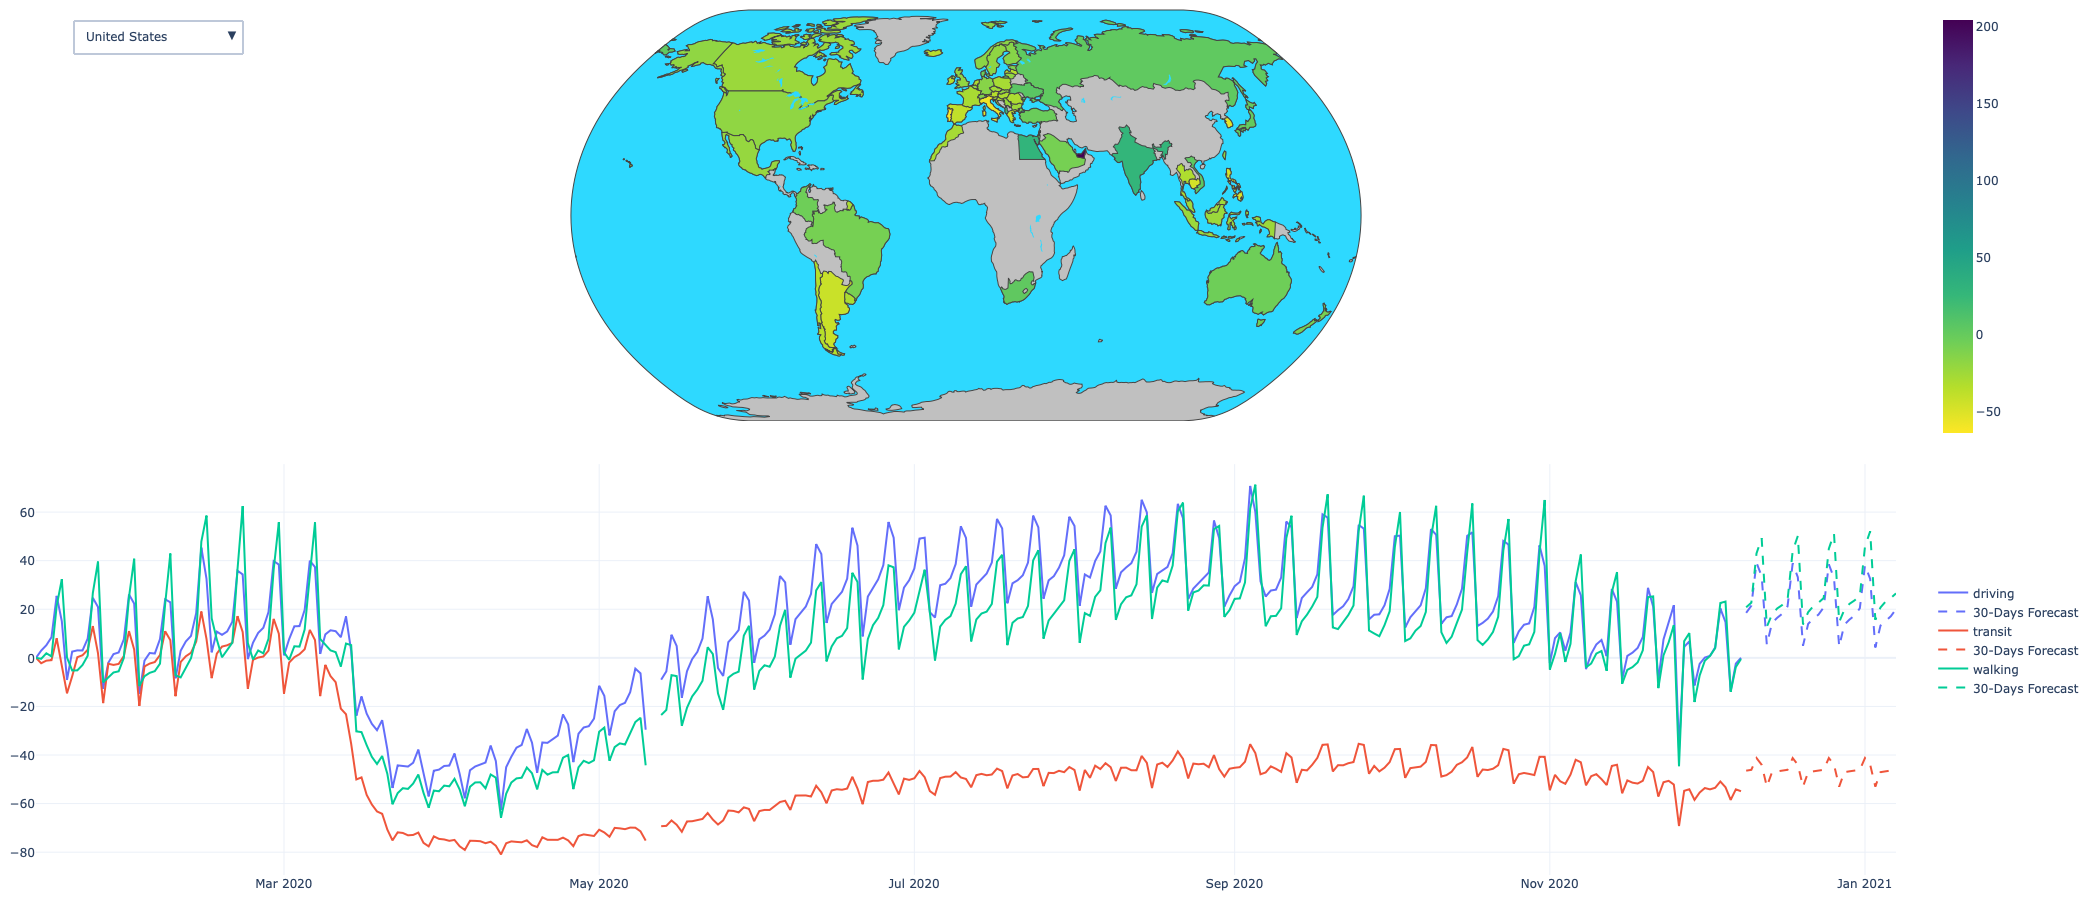

In [18]:
# define default country
default_country = 'United States'
# define lists fort keeping track of added plots and buttons
add_country_plots = []
buttons = []
line_color = ['#636EFA', '#EF553B', '#00CC96']

# create figure
fig = go.Figure()
# define layout
fig = make_subplots(rows = 6, cols = 10,
                   specs = [
                       [{'type': "choropleth", "rowspan":3, "colspan": 10}, None, None, None, None, None, None, None, None, None],
                       [None, None, None, None, None, None, None, None, None, None],
                       [None, None, None, None, None, None, None, None, None, None],
                       [{'type': 'scatter', "rowspan":3, "colspan": 10}, None, None, None, None, None, None, None, None, None],
                       [None, None, None, None, None, None, None, None, None, None],
                       [None, None, None, None, None, None, None, None, None, None]
                   ])
# define most recent trend by taking the mean of transportation types
most_recent_trends = [trends_countries[c].iloc[-1, :].mean().round(2) for c in country_names]
# add scatter geo map 
# fig.add_trace(go.Scattergeo(locations = country_names,
#                             locationmode = "country names",
#                             mode = 'markers',
#                             text = [str(trend) + " %" for trend in most_recent_trends],
#                             marker_color = most_recent_trends,
#                             visible = True,
#                             name = 'Countries',
#                             showlegend = False),
#               row = 1, col = 1
#              )
fig.add_trace(go.Choropleth(locations = country_names,
                            locationmode = "country names",
                            z = most_recent_trends,
                            visible = True,
                            text = [str(trend) + " %" for trend in most_recent_trends],
                            hoverinfo = "location + text",
                            name = 'Countries',
                            colorscale="Viridis",
                            reversescale = True,
                            showlegend = False,
                            colorbar = dict(len = 0.5,
                                            x = 1.02,
                                            y = 0.75)
                           ),
              row = 1, col = 1
             )

# add scatter trace for each transportation type and for each country
# loop through country, get corresponding dataframe and projection for each transportation type
for country in country_names:
    # get historical trend
    country_trend = get_country_trend(trends_countries, country_names, country_name = country)    
    # get forecast
    country_forecast = get_country_forecast(forecast_countries, country_names, country_name = country)
    # loop through each available transportation type in a country
    for idx, transportation in enumerate(country_trend.columns):
        # add trace of historical trends
        fig.add_trace(go.Scatter(x =country_trend.index, 
                                 y = country_trend[transportation], 
                                 mode = 'lines', 
                                 line = dict(color = line_color[idx]),
                                 name = transportation,
                                 visible = (country == default_country), # keep default visible only
                                ), 
                      row = 4, col = 1
                     )
        # update lists
        add_country_plots.append(country)
        # add trace of forecasted trends
        fig.add_trace(go.Scatter(x = country_forecast.index,
                                 y = country_forecast[transportation],
                                 line = dict(color = line_color[idx], 
                                             width = 2, 
                                             dash='dash'
                                            ),
                                 mode = 'lines',
                                 name = '30-Days Forecast',
                                 visible = (country == default_country), # keep default visible only
                                ),
                      row = 4, col = 1
                     )
        # update lists
        add_country_plots.append(country)

# Update plot sizing
fig.update_layout(
    template="plotly_white",
    width=1500,
    height=900,
    autosize=False,
    margin=dict(t=10, b=10, l=10, r=10),
    geo = dict(projection_type = "natural earth",
#                showcoastlines=True,
#                showcountries = True, 
               countrycolor = "RebeccaPurple", landcolor = 'silver',
               showocean = True, oceancolor = "#2ED9FF", lakecolor = "#2ED9FF",
               showland = True, 
               showframe = True
              ),
    legend = dict(x = 1.02,
                  y = 0.2
                 )
)

# add button for each country
# loop through country and configure button
# button visibility controls for what trace to appear, correspond to add_country_plots
for country in country_names:
    buttons.append(dict(method='update',
                        label=country,
                        args = [{'visible': [True] + [country == c for c in add_country_plots]}])) # start with a True to take scatter geo into account

# Add dropdown
fig.update_layout(
    updatemenus=[
        dict(
            buttons = buttons,
            direction = "down",
            pad = {"r": 10, "t": 10},
            showactive = True,
            active = list(country_names).index(default_country),
            x = 0.02,
            xanchor = "left",
            y = 1,
            yanchor = "top"
        ),
    ]
)

fig.show()